In [1]:
import os
from os import listdir
from os.path import isfile, join
import ntpath

wave_dirs = ['/home/scpark/ai/datasets/kss/1',
             '/home/scpark/ai/datasets/kss/2',
             '/home/scpark/ai/datasets/kss/3',
             '/home/scpark/ai/datasets/kss/4']

wave_files = []
for wave_dir in wave_dirs:
    wave_files += [join(wave_dir, f) for f in listdir(wave_dir) if isfile(join(wave_dir, f)) if 'wav' in f]
print(len(wave_files))

wave_files.sort()

12854


(10, 128, 207)


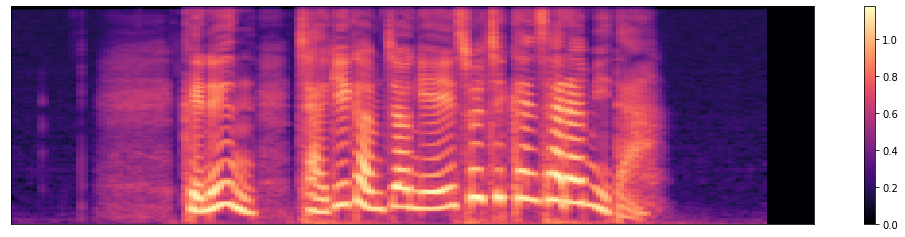

In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from PIL import Image

def get_data(batch_size=10, n_mels=128):
    
    indexes = np.random.randint(0, len(wave_files), batch_size)
    mels = []
    max_length = 0
    for i in indexes:
        wav, _ = librosa.core.load(wave_files[i])

        spec = librosa.core.stft(wav, n_fft=2048, hop_length=512)
        spec = np.abs(spec)

        mel_basis = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=n_mels)
        mel = mel_basis @ spec
        
        def dynamic_range_compression(x, min_db=-100, max_db=0):
            db = 20 * np.log10(np.maximum(x, 1e-5))
            db -= min_db
            db /= (max_db - min_db)
            return db

        mel = dynamic_range_compression(mel)
        mels.append(mel)
        
        if max_length < mel.shape[1]:
            max_length = mel.shape[1]
        
    padded_mels = []
    for mel in mels:
        mel = np.pad(mel, ((0, 0), (0, max_length - mel.shape[1])), 'constant', constant_values=0)
        padded_mels.append(mel)
    
    padded_mels = np.stack(padded_mels)
    return padded_mels


_mels = get_data(10)
print(_mels.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_mels[0])
plt.colorbar()
plt.show()

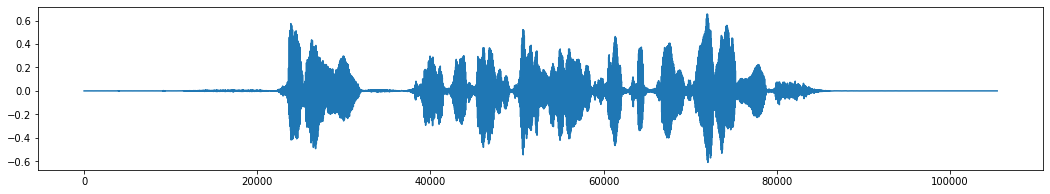

In [4]:
import scipy 

def mel_to_wave(mel, fmax=8000):
    # mel : [T, C]
    def dynamic_range_decompression(y, min_db=-100, max_db=0):
        amp = y * (max_db - min_db)
        amp += min_db
        amp = np.power(10.0, amp * 0.05)
        return amp
    
    mel = dynamic_range_decompression(mel)
    mel_basis = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=mel.shape[0], fmax=fmax)
    inv_basis = np.linalg.pinv(mel_basis)
    spec = inv_basis @ mel
    
    wave = librosa.core.griffinlim(spec, hop_length=512)
    return wave

wave = mel_to_wave(_mels[0], fmax=None)

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm_notebook as tqdm

ratio = 4

'''
Flow Modules
'''
class NonLinearConditional(nn.Module):
    def __init__(self, hparams):
        super(NonLinearConditional, self).__init__()
        input_channels = hparams.n_mel_channels * int(ratio/2)
        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=int(hparams.non_linear_dim/2), bidirectional=True)
        #self.lstm = torch.nn.utils.weight_norm(self.lstm, name='weight')
        
        self.out_projection = nn.Sequential(nn.Linear(hparams.non_linear_dim, hparams.non_linear_dim),
                                            nn.ReLU(),
                                            nn.Linear(hparams.non_linear_dim, input_channels))
        #self.out_projection = torch.nn.utils.weight_norm(self.out_projection, name='weight')
        
            
        
    def forward(self, x):
        # x : [B, T, C]
        x = x.transpose(0, 1)
        x, _ = self.lstm(x)
        x = x.transpose(0, 1)
        x = self.out_projection(x)
        
        return x
    
class Invertible1x1Conv(torch.nn.Module):
    """
    The layer outputs both the convolution, and the log determinant
    of its weight matrix.  If reverse=True it does convolution with
    inverse
    """
    def __init__(self, c):
        super(Invertible1x1Conv, self).__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        W = torch.eye(c)
        self.W = nn.Parameter(W)
            
    def forward(self, z, reverse=False):
        # shape
        batch_size, time, channels = z.size()

        if reverse:
            # Reverse computation
            W_inverse = self.W.inverse()
            z = F.linear(z, W_inverse)
            return z
        else:
            # Forward computation
            log_det_W = torch.logdet(self.W)
            z = F.linear(z, self.W)
            return z, log_det_W
    
class CouplingLayer(nn.Module):
    def __init__(self, hparams):
        super(CouplingLayer, self).__init__()
        self.non_linear_conditional = NonLinearConditional(hparams)
        self.inv1x1conv = Invertible1x1Conv(hparams.n_mel_channels * ratio)
        self.hparams = hparams
    
    def forward(self, x):
        #print('coupling in :', x.size())
        # x : [B, T, C]
        
        x, log_det_W = self.inv1x1conv(x)
        
        # split
        x_a = x[:, :, :int(x.size(2) / 2)]
        x_b = x[:, :, int(x.size(2) / 2):]
        
        # non-linear layer
        m = self.non_linear_conditional(x_a)
        x_b = x_b + m

        # merge
        y = torch.cat([x_a, x_b], dim=2)
        
        return y, log_det_W
    
    def inverse(self, y):
        # y : [B, T, C]
        
        # split
        y_a = y[:, :, :int(y.size(2) / 2)]
        y_b = y[:, :, int(y.size(2) / 2):]
        
        # non-linear layer
        m = self.non_linear_conditional(y_a)
        y_b = y_b - m

        # merge
        x = torch.cat([y_a, y_b], dim=2)
        
        x = self.inv1x1conv(x, reverse=True)
           
        return x
    
class Flow(nn.Module):
    def __init__(self, hparams):
        super(Flow, self).__init__()
        
        coupling_layers = [CouplingLayer(hparams) for i in range(hparams.coupling_layers_num)]
        self.coupling_layers = nn.ModuleList(coupling_layers)
        
    def squeeze(self, x):
        x = torch.reshape(x, [x.size(0), -1, x.size(2) * ratio])
        return x
        
    def unsqueeze(self, y):
        y = torch.reshape(y, [y.size(0), -1, int(y.size(2) / ratio)])
        return y
        
    def forward(self, x):
        # x : [B, C, T]
        
        # [B, T, C]
        x = x.transpose(1, 2)
        x = F.pad(x, (0, 0, 0, ratio - (x.size(1) % ratio)))
        x = self.squeeze(x)
        log_det_W_list = []
        for coupling_layer in self.coupling_layers:
            x, log_det_W = coupling_layer(x)
            log_det_W_list.append(log_det_W)
            
        z = x
        
        # [B, C, T]
        z = z.transpose(1, 2)
        
        return z, log_det_W_list
        
    def inverse(self, z):
        # z : [B, C, T]
        
        # [B, T, C]
        z = z.transpose(1, 2)
        for coupling_layer in reversed(self.coupling_layers):
            z = coupling_layer.inverse(z)
        
        z = self.unsqueeze(z)
        # [B, C, T]
        x = z.transpose(1, 2)
        
        return x
        
'''
Flow Modules End
'''

'\nFlow Modules End\n'

In [6]:
import tensorflow as tf

hparams = tf.contrib.training.HParams(coupling_layers_num=8, 
                                     n_mel_channels=128,
                                     non_linear_dim=512)

W1015 14:04:03.428773 140319601043264 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/torch_mel128_lstm'            
logger = Logger(save_dir)

In [14]:
def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 86000
GPU = 0

model = Flow(hparams)
model.cuda(GPU)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

path = get_save_path(save_dir, step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path)    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')



print('done')


loaded
done


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time

def get_loss(z, log_det_W_list):
    
    log_det_W_list = torch.stack(log_det_W_list)
    
    log_likelihoods = torch.sum(-0.5 * (z ** 2 + np.log(2. * np.pi)), dim=1) + torch.sum(log_det_W_list)
    flow_loss = torch.mean(-log_likelihoods) / hparams.n_mel_channels
    
    return flow_loss

while(True):
    for _ in tqdm(range(100)):
        print(step)
        model.zero_grad()
        
        _mels = get_data(16)
        mels = torch.from_numpy(_mels).float().cuda(GPU)
        
        z, log_det_W_list = model(mels)
        loss = get_loss(z, log_det_W_list)
        print(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)
        
        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            
            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
        step += 1
            
    clear_output()
    
    z = z.data.cpu().numpy()
    z = z.reshape([-1])
    plt.hist(z, bins=100)
    plt.show()
    
    z = mels.data.new(1, 128 * ratio, 100).normal_()
    mels_recon = model.inverse(z)
    _mels_recon = mels_recon.data.cpu().numpy()
    print(_mels_recon.shape)
    
    plt.figure(figsize=[18, 4])
    librosa.display.specshow(_mels[0])
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=[18, 4])
    librosa.display.specshow(_mels_recon[0])
    plt.colorbar()
    plt.show()
    
     

91435
-9.820703506469727
91436
-9.952320098876953
91437
-9.741557121276855
91438
-9.918171882629395
91439
-10.009528160095215
91440
-9.989992141723633
91441
-10.288352966308594
91442
-10.119294166564941
91443
-10.080103874206543
91444
-10.37989616394043
91445
-10.28403091430664
91446
-10.523950576782227
91447
-10.369251251220703
91448
-9.980805397033691
91449
-10.544442176818848
91450
-9.977608680725098
91451
-9.86602783203125
91452
-9.826933860778809
91453


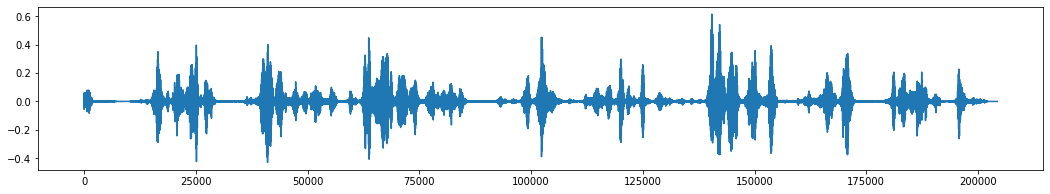

In [44]:
wave = mel_to_wave(_mels_recon[0], fmax=None)

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)